## Installing Libraries

In [1]:
%%capture
!pip install yfinance
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install joblib
!pip install seaborn
!pip install numpy

## Importing necessary packages

In [2]:
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Ticker of interest

In [3]:
name = "QQQ"
#def stock(name,start,end):
ticker = yfinance.Ticker(name)
df = ticker.history(interval="1d",start="2019-11-04",end="2022-11-15")


## Checking Data 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 764 entries, 2019-11-04 00:00:00-05:00 to 2022-11-14 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          764 non-null    float64
 1   High          764 non-null    float64
 2   Low           764 non-null    float64
 3   Close         764 non-null    float64
 4   Volume        764 non-null    int64  
 5   Dividends     764 non-null    float64
 6   Stock Splits  764 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 47.8 KB


In [5]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-11-04 00:00:00-05:00,196.697404,197.031469,195.400427,196.608978,19015900,0.0,0
2019-11-05 00:00:00-05:00,196.854628,197.051136,196.068583,196.717072,15048900,0.0,0
2019-11-06 00:00:00-05:00,196.491096,196.510751,195.321855,196.274933,19725500,0.0,0
2019-11-07 00:00:00-05:00,197.257472,198.200730,196.363360,196.933228,17832400,0.0,0
2019-11-08 00:00:00-05:00,196.579518,197.738924,196.058751,197.719269,15258800,0.0,0


## Defining period and multiplier for rolling calcualtions 

In [6]:
period=20
multiplier=1.7

In [7]:
df['MiddleBand']= df['Close'].rolling(period).mean()
df['UpperBand'] = df['Close'].rolling(period).mean() + df['Close'].rolling(period).std() * multiplier
df['LowerBand'] = df['Close'].rolling(period).mean() - df['Close'].rolling(period).std() * multiplier

## Plotting Bolinger Bnd

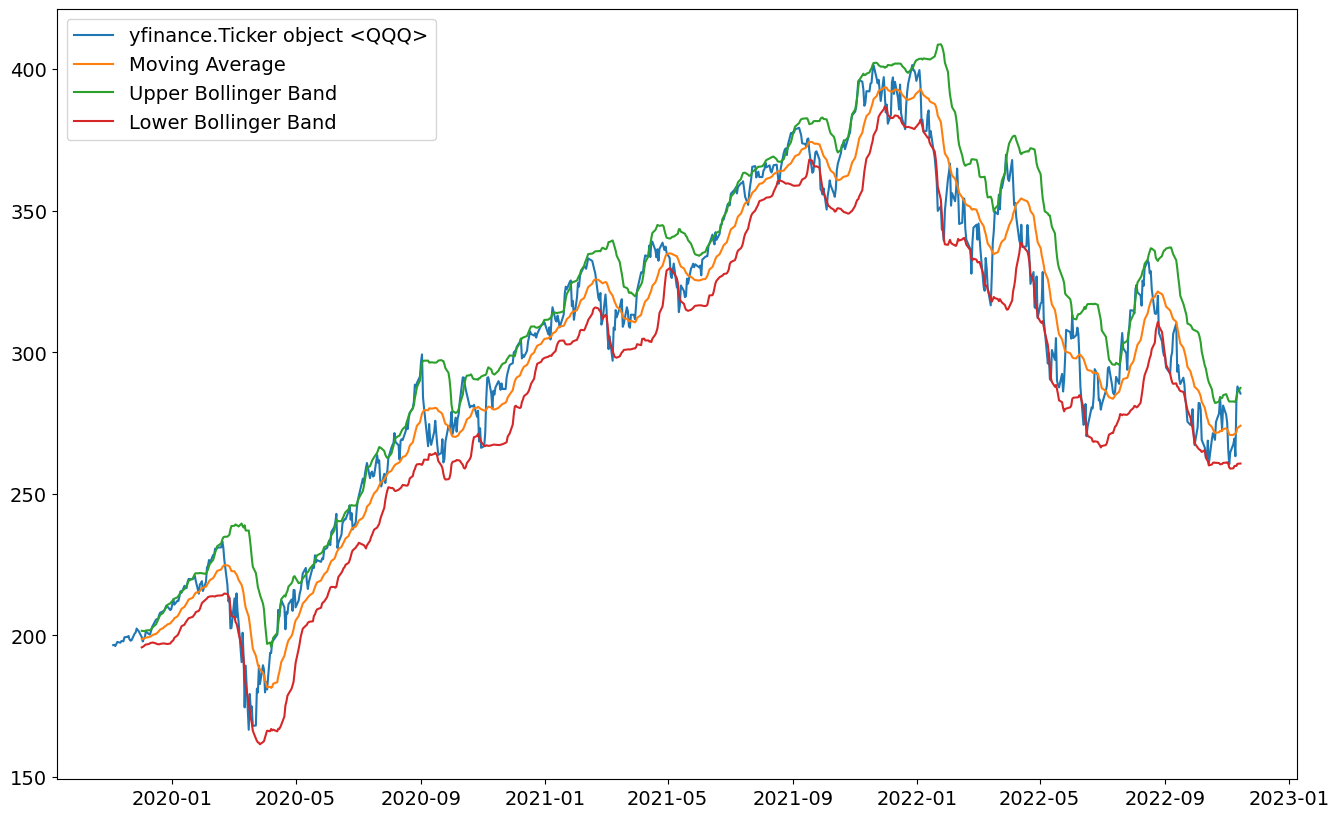

In [8]:
#https://medium.com/codex/how-to-calculate-bollinger-bands-of-a-stock-with-python-f9f7d1184fc3
plt.rcParams['figure.figsize'] = [16, 10]

plt.rc('font', size=14)

plt.plot(df['Close'], label = ticker)
plt.plot(df['MiddleBand'], label = "Moving Average")
plt.plot(df['UpperBand'], label = "Upper Bollinger Band")
plt.plot(df['LowerBand'], label = "Lower Bollinger Band")

plt.legend()

plt.show()

## Implementing buy and sell strategy using bollinger bands

In [9]:
##https://medium.com/codex/algorithmic-trading-with-bollinger-bands-in-python-1b0a00c9ef99
#https://medium.com/codex/algorithmic-trading-with-bollinger-bands-in-python-1b0a00c9ef99
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

buy_price, sell_price, bb_signal = implement_bb_strategy(df['Close'], df['LowerBand'], df['UpperBand'])


### Investment strategy

#### Creating a  position list to see if we already have the stock: 1 if we already own the stock 

In [10]:
position = []
for i in range(len(bb_signal)):
    if bb_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['Close'])):
    if bb_signal[i] == 1:
        position[i] = 1
    elif bb_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
upper_bb = df['UpperBand']
lower_bb = df['LowerBand']
close_price = df['Close']
bb_signal = pd.DataFrame(bb_signal).rename(columns = {0:'bb_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'bb_position'}).set_index(df.index)

frames = [close_price, upper_bb, lower_bb, bb_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index().drop('Date', axis = 1)

strategy

,Close,UpperBand,LowerBand,bb_signal,bb_position
0,196.608978,NaN,NaN,0,1
1,196.717072,NaN,NaN,0,1
2,196.274933,NaN,NaN,0,1
3,196.933228,NaN,NaN,0,1
4,197.719269,NaN,NaN,0,1
...,...,...,...,...,...
759,269.540009,282.552126,259.826872,0,0
760,263.320007,282.512304,259.932694,0,0
761,282.750000,283.973800,259.864198,0,0
762,287.959991,285.921730,260.638267,0,0


### Plotting Buyback signals on bollinger bands

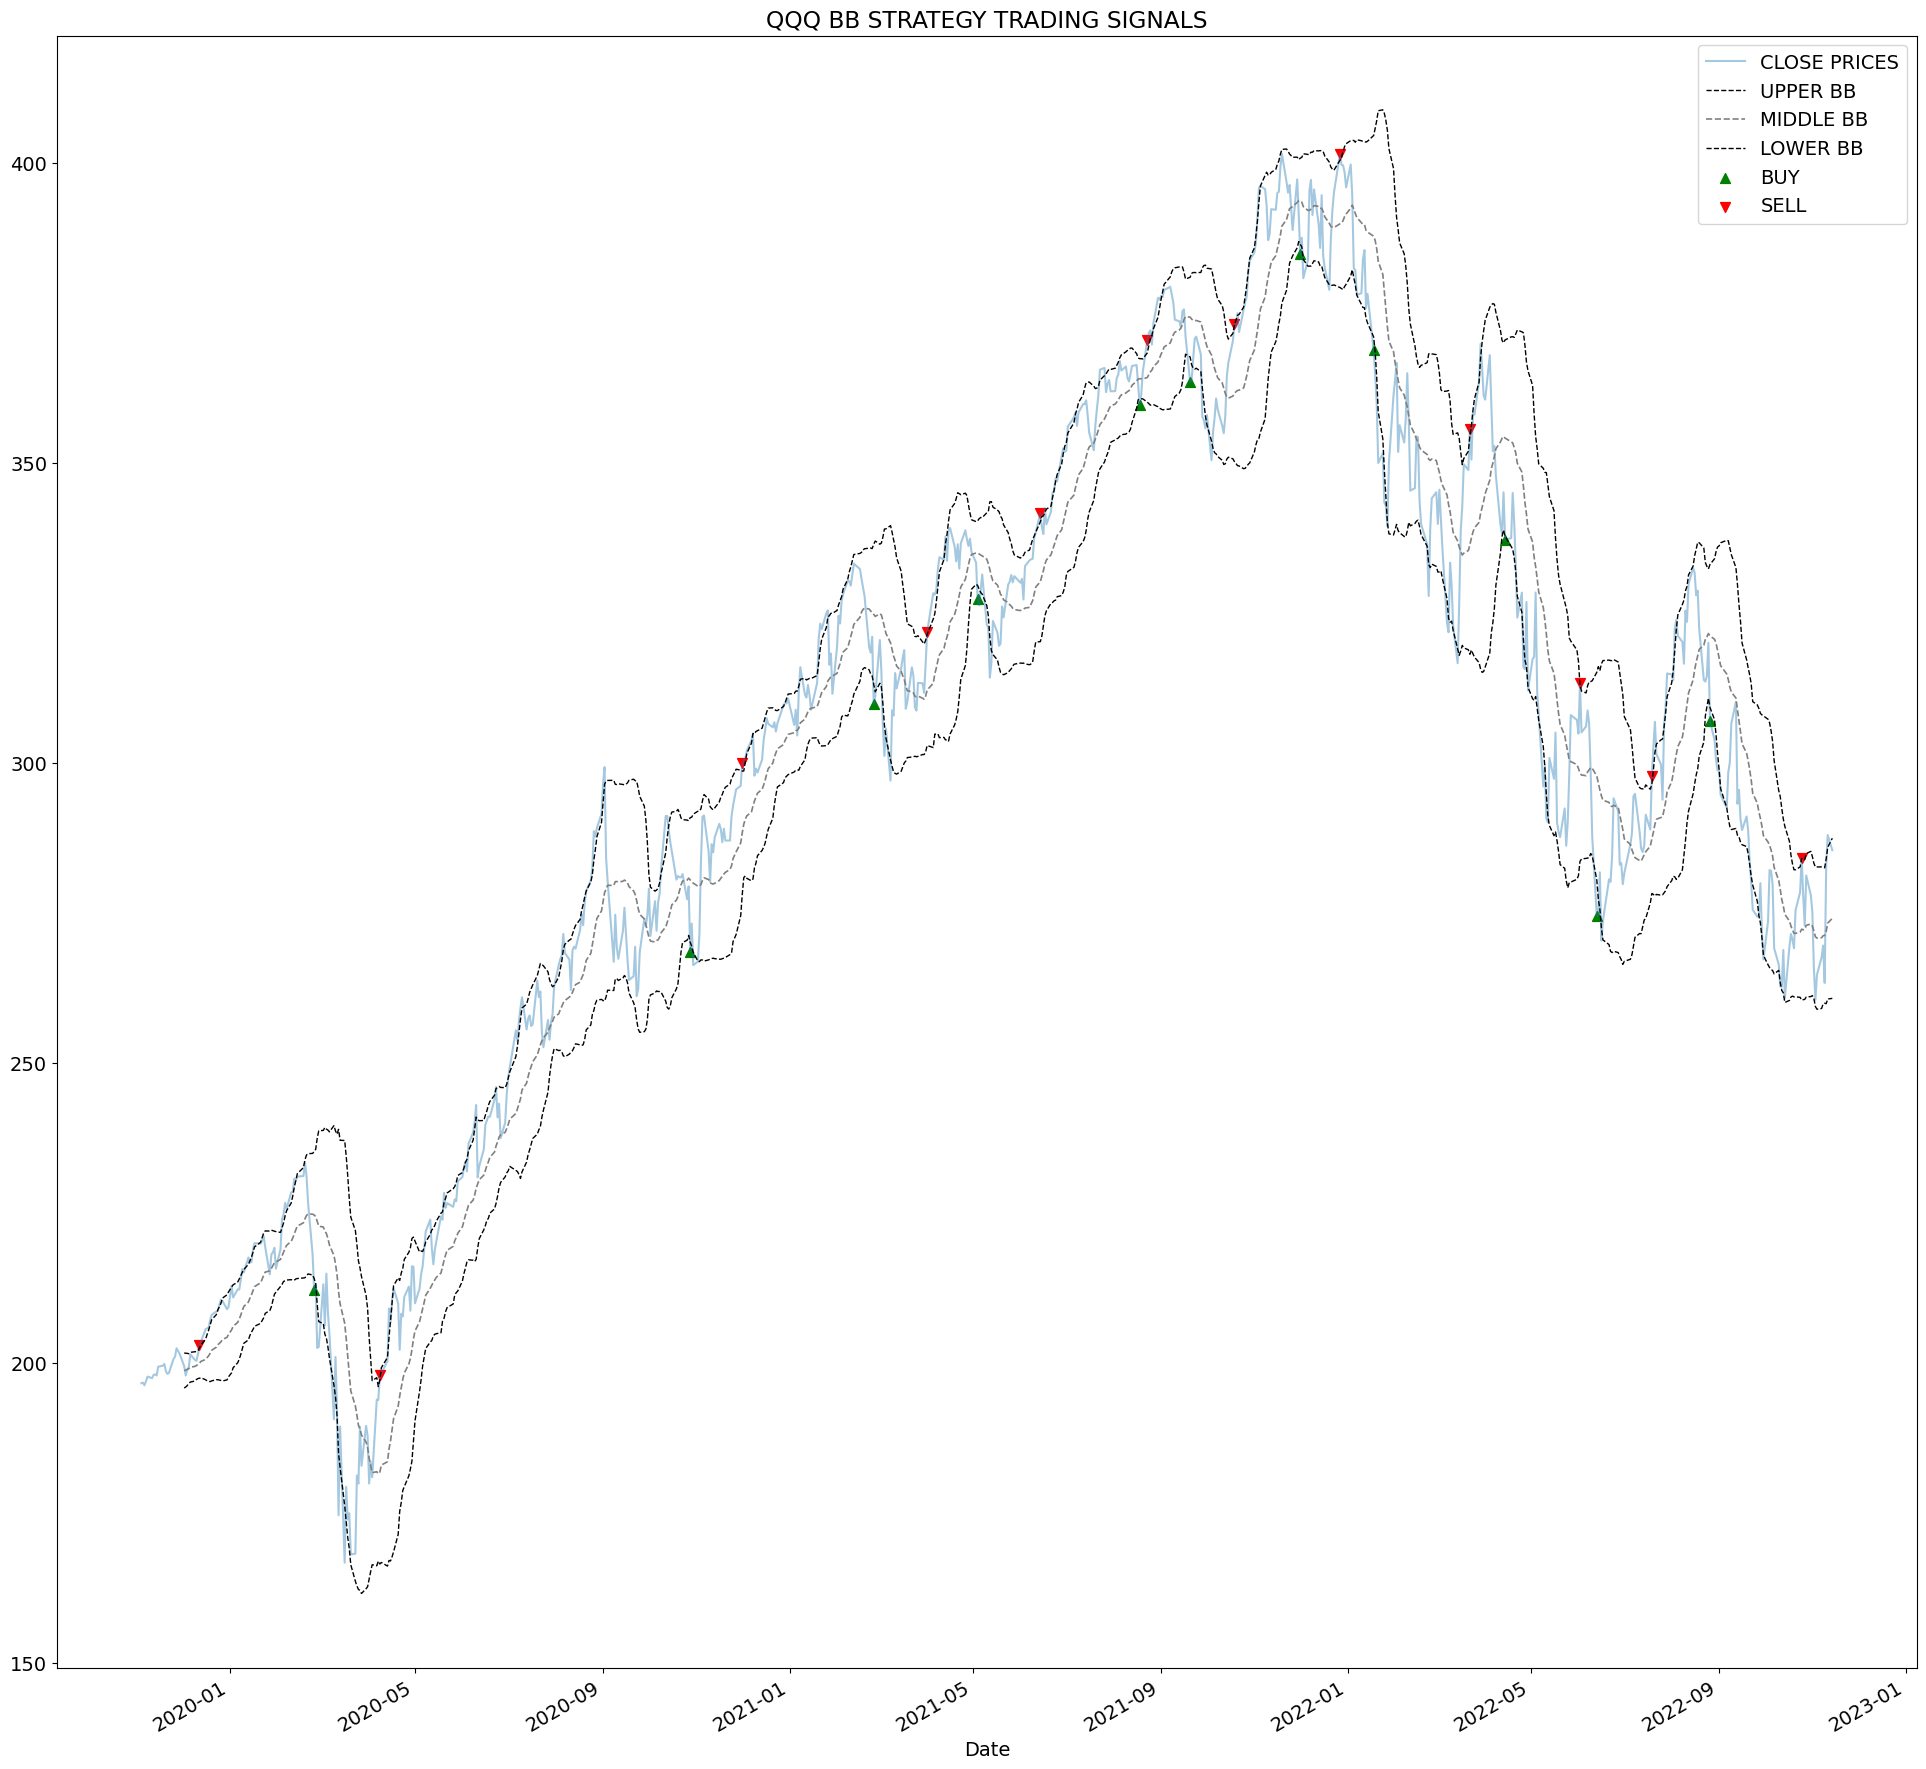

In [11]:
plt.rcParams['figure.figsize'] = [24,24]
plt.rc('font', size=14)
df['Close'].plot(label = 'CLOSE PRICES', alpha = 0.4)
df['UpperBand'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
df['MiddleBand'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
df['LowerBand'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 50)
plt.scatter(df.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 50)
plt.title('QQQ BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper right')
plt.show()

__Back Testing to see how the trading strategy is working__

In [12]:
import math
df_ret = pd.DataFrame(np.diff(df['Close'])).rename(columns = {0:'returns'})
bb_strategy_ret = []

for i in range(len(df_ret)):
    try:
        returns = df_ret['returns'][i]*strategy['bb_position'][i]
        bb_strategy_ret.append(returns)
    except:
        pass
    
bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df['Close'][-1])
bb_investment_ret = []

for i in range(len(bb_strategy_ret_df['bb_returns'])):
    returns = number_of_stocks*bb_strategy_ret_df['bb_returns'][i]
    bb_investment_ret.append(returns)

bb_investment_ret_df = pd.DataFrame(bb_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(bb_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print('Profit gained from the BB strategy by investing $100k in df : {}'.format(total_investment_ret))
print('Profit percentage of the BB strategy : {}%'.format(profit_percentage))


Profit gained from the BB strategy by investing $100k in df : 17833.46
Profit percentage of the BB strategy : 17%


### Using cufflinks for displaying bollingerband with candlestick

In [13]:
%%capture
## https://github.com/Worlddatascience/DataScienceCohort/blob/master/6_How_to_Create_a_Candlestick_Chart_using_Python.ipynb
!pip install cufflinks
## Code to Install Backtrader
!pip install backtrader 
import cufflinks as cf   #A powerful data visualization library used for Financial Data Science processes
from plotly.offline import iplot, init_notebook_mode #Plotly and cufflinks work in conjunction

cf.go_offline() #gives ability to plot offline
init_notebook_mode() #gives ability to plot things proportionately in the notebook


In [14]:
plt.rcParams['figure.figsize'] = [24,24]
plt.rc('font', size=14)
Candlestick= cf.QuantFig(df, title='QQQ', legend='top', name='QQQ')

In [15]:
Candlestick.add_bollinger_bands(periods=20, boll_std=2, fill=True, column='Close')
Candlestick.add_volume() 
#Candlestick.add_dmi()#Adding parameters for a Volume chart (measure of shares and trading volume over a specified time)
#Candlestick.add_sma(periods=20, column='Close', color='red') #Simple Moving Average for a 20 day period 
#A 20-day moving average would average out the closing prices for the first 20 days as the first data point.
#Candlestick.add_ema(periods=20, color='green') #Exponential Moving Average for a 20 day period

In [16]:
Candlestick.iplot()
